<a href="https://www.kaggle.com/code/bhavinmoriya/learnquant?scriptVersionId=257169552" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

=== Quantitative Portfolio Analysis ===

1. Generating sample market data...
Generated 1000 days of data for 8 assets

2. Fitting factor model...
Factor model fitted successfully
Factor loadings shape: (8, 3)

3. Portfolio optimization...
Optimal portfolio weights:
  Asset_1: 0.158
  Asset_2: 0.284
  Asset_3: 0.016
  Asset_4: 0.102
  Asset_5: 0.079
  Asset_6: 0.106
  Asset_7: 0.184
  Asset_8: 0.070

4. Running backtest...

5. Performance Analysis...

Strategy Performance:
  Total Return: 0.6653
  Annualized Return: 0.1522
  Annualized Volatility: 0.1622
  Sharpe Ratio: 0.8148
  Sortino Ratio: 1.1480
  Max Drawdown: -0.1881
  VaR (95%): -0.0162
  CVaR (95%): -0.0224
  Skewness: 0.2256
  Kurtosis: 2.0789
  Beta: 0.9710
  Alpha: 0.1127

Benchmark Performance:
  Total Return: 0.1395
  Annualized Return: 0.0401
  Annualized Volatility: 0.1130
  Sharpe Ratio: 0.1776
  Sortino Ratio: 0.2939
  Max Drawdown: -0.1641
  VaR (95%): -0.0117
  CVaR (95%): -0.0147
  Skewness: 0.0069
  Kurtosis: 0.109

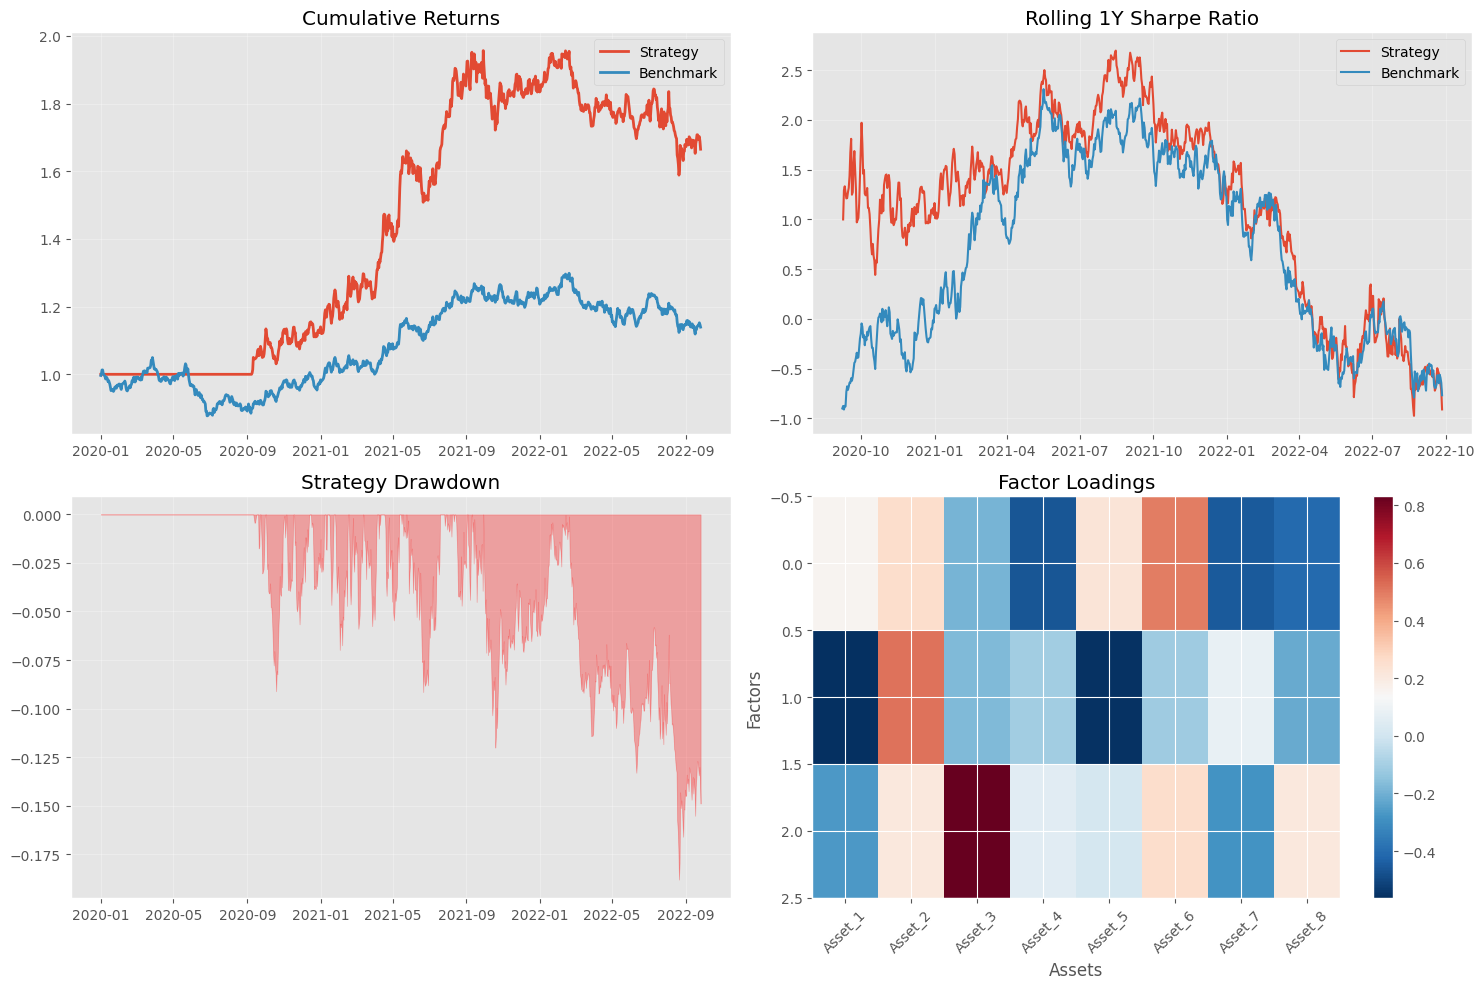


7. Monte Carlo stress testing...
Monte Carlo Results (1000 simulations):
  Expected Annual Return: -0.2814
  Expected Annual Volatility: 2.6259
  Expected Sharpe Ratio: -0.1054
  5th Percentile Return: -0.9997
  95th Percentile Return: 1.0007

=== Analysis Complete ===
This project demonstrates:
• Multi-factor risk modeling
• Portfolio optimization with constraints
• Systematic strategy backtesting
• Comprehensive risk metrics
• Monte Carlo stress testing
• Professional visualization


In [1]:
"""
Multi-Strategy Quantitative Portfolio Optimization System
========================================================

This project demonstrates key quantitative finance concepts including:
- Factor modeling and risk decomposition
- Portfolio optimization with multiple constraints
- Backtesting framework with transaction costs
- Risk metrics and performance attribution
- Monte Carlo simulation for stress testing

Author: [Your Name]
Date: August 2025
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import seaborn as sns
from scipy import optimize
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

class FactorModel:
    """
    Multi-factor risk model implementation
    """
    
    def __init__(self, n_factors=3):
        self.n_factors = n_factors
        self.factor_loadings = None
        self.factor_returns = None
        self.specific_risk = None
        
    def fit(self, returns_df):
        """Fit factor model using PCA"""
        # Standardize returns
        standardized_returns = (returns_df - returns_df.mean()) / returns_df.std()
        
        # Apply PCA
        pca = PCA(n_components=self.n_factors)
        self.factor_returns = pd.DataFrame(
            pca.fit_transform(standardized_returns),
            index=returns_df.index,
            columns=[f'Factor_{i+1}' for i in range(self.n_factors)]
        )
        
        # Calculate factor loadings
        self.factor_loadings = pd.DataFrame(
            pca.components_.T,
            index=returns_df.columns,
            columns=[f'Factor_{i+1}' for i in range(self.n_factors)]
        )
        
        # Calculate specific risk (residual variance)
        predicted_returns = self.factor_returns @ self.factor_loadings.T
        residuals = standardized_returns - predicted_returns
        self.specific_risk = pd.Series(
            residuals.var(),
            index=returns_df.columns
        )
        
        return self
    
    def get_factor_covariance(self):
        """Calculate factor covariance matrix"""
        return self.factor_returns.cov().values
    
    def get_total_covariance(self):
        """Calculate total covariance matrix"""
        factor_cov = self.get_factor_covariance()
        loadings = self.factor_loadings.values
        
        # Factor contribution
        factor_contribution = loadings @ factor_cov @ loadings.T
        
        # Add specific risk
        specific_cov = np.diag(self.specific_risk.values)
        
        return factor_contribution + specific_cov

class PortfolioOptimizer:
    """
    Portfolio optimization with multiple objectives and constraints
    """
    
    def __init__(self, expected_returns, covariance_matrix, factor_model=None):
        self.expected_returns = expected_returns
        self.covariance_matrix = covariance_matrix
        self.factor_model = factor_model
        self.n_assets = len(expected_returns)
        
    def optimize_portfolio(self, risk_aversion=1.0, constraints=None):
        """
        Optimize portfolio using mean-variance optimization
        """
        if constraints is None:
            constraints = {}
            
        # Objective function: maximize utility (return - risk_aversion * risk)
        def objective(weights):
            portfolio_return = np.dot(weights, self.expected_returns)
            portfolio_risk = np.sqrt(np.dot(weights, np.dot(self.covariance_matrix, weights)))
            return -(portfolio_return - risk_aversion * portfolio_risk)
        
        # Constraints
        cons = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]  # weights sum to 1
        
        # Add custom constraints
        if 'max_weight' in constraints:
            for i in range(self.n_assets):
                cons.append({'type': 'ineq', 'fun': lambda w, i=i: constraints['max_weight'] - w[i]})
        
        if 'min_weight' in constraints:
            for i in range(self.n_assets):
                cons.append({'type': 'ineq', 'fun': lambda w, i=i: w[i] - constraints['min_weight']})
        
        # Bounds
        bounds = tuple((-0.5, 1.0) for _ in range(self.n_assets))  # Allow some shorting
        
        # Initial guess
        x0 = np.ones(self.n_assets) / self.n_assets
        
        # Optimize
        result = optimize.minimize(
            objective, x0, method='SLSQP', 
            bounds=bounds, constraints=cons
        )
        
        if result.success:
            return result.x
        else:
            raise ValueError("Optimization failed")
    
    def efficient_frontier(self, n_portfolios=50):
        """Calculate efficient frontier"""
        min_ret = self.expected_returns.min()
        max_ret = self.expected_returns.max()
        target_returns = np.linspace(min_ret, max_ret, n_portfolios)
        
        efficient_portfolios = []
        
        for target_ret in target_returns:
            try:
                # Minimize risk for target return
                def objective(weights):
                    return np.dot(weights, np.dot(self.covariance_matrix, weights))
                
                cons = [
                    {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
                    {'type': 'eq', 'fun': lambda w: np.dot(w, self.expected_returns) - target_ret}
                ]
                
                bounds = tuple((0, 1) for _ in range(self.n_assets))
                x0 = np.ones(self.n_assets) / self.n_assets
                
                result = optimize.minimize(objective, x0, method='SLSQP', bounds=bounds, constraints=cons)
                
                if result.success:
                    portfolio_return = np.dot(result.x, self.expected_returns)
                    portfolio_risk = np.sqrt(np.dot(result.x, np.dot(self.covariance_matrix, result.x)))
                    efficient_portfolios.append({
                        'return': portfolio_return,
                        'risk': portfolio_risk,
                        'weights': result.x
                    })
            except:
                continue
                
        return efficient_portfolios

class BacktestEngine:
    """
    Backtesting framework with transaction costs and performance metrics
    """
    
    def __init__(self, returns_data, transaction_cost=0.001):
        self.returns_data = returns_data
        self.transaction_cost = transaction_cost
        
    def backtest_strategy(self, weight_function, rebalance_freq='M', lookback_window=252):
        """
        Backtest a strategy given a weight function
        """
        returns = self.returns_data.copy()
        dates = returns.index
        
        # Resample for rebalancing
        if rebalance_freq == 'M':
            rebalance_dates = pd.date_range(start=dates[0], end=dates[-1], freq='M')
        elif rebalance_freq == 'Q':
            rebalance_dates = pd.date_range(start=dates[0], end=dates[-1], freq='Q')
        else:
            rebalance_dates = dates
            
        portfolio_returns = []
        portfolio_weights = []
        turnover = []
        
        current_weights = None
        
        for i, date in enumerate(dates):
            # Initialize turnover for all dates
            daily_turnover = 0.0
            
            if i < lookback_window:
                portfolio_returns.append(0.0)
                portfolio_weights.append(None)
                turnover.append(daily_turnover)
                continue
                
            # Check if rebalancing date
            if date in rebalance_dates or current_weights is None:
                # Get historical data for weight calculation
                hist_data = returns.iloc[i-lookback_window:i]
                
                try:
                    # Calculate new weights
                    new_weights = weight_function(hist_data)
                    
                    # Calculate turnover (sum of absolute weight changes)
                    if current_weights is not None:
                        daily_turnover = np.sum(np.abs(new_weights - current_weights))
                    else:
                        daily_turnover = np.sum(np.abs(new_weights))
                        
                    current_weights = new_weights
                    
                except Exception as e:
                    # If optimization fails, use equal weights
                    new_weights = np.ones(len(returns.columns)) / len(returns.columns)
                    current_weights = new_weights
                    daily_turnover = 0.0
                
            # Calculate portfolio return
            if current_weights is not None:
                daily_return = np.dot(current_weights, returns.iloc[i])
                # Subtract transaction costs
                daily_return -= daily_turnover * self.transaction_cost
                portfolio_returns.append(daily_return)
            else:
                portfolio_returns.append(0.0)
                
            portfolio_weights.append(current_weights.copy() if current_weights is not None else None)
            turnover.append(daily_turnover)
        
        results = {
            'returns': pd.Series(portfolio_returns, index=dates),
            'weights': portfolio_weights,
            'turnover': pd.Series(turnover, index=dates)
        }
        
        return results

class RiskMetrics:
    """
    Comprehensive risk and performance metrics
    """
    
    @staticmethod
    def calculate_metrics(returns_series, benchmark_returns=None, risk_free_rate=0.02):
        """Calculate comprehensive performance metrics"""
        returns = returns_series.dropna()
        
        # Basic metrics
        total_return = (1 + returns).prod() - 1
        annualized_return = (1 + returns.mean()) ** 252 - 1
        annualized_vol = returns.std() * np.sqrt(252)
        sharpe_ratio = (annualized_return - risk_free_rate) / annualized_vol
        
        # Downside metrics
        downside_returns = returns[returns < 0]
        downside_vol = downside_returns.std() * np.sqrt(252)
        sortino_ratio = (annualized_return - risk_free_rate) / downside_vol if len(downside_returns) > 0 else np.nan
        
        # Drawdown metrics
        cumulative = (1 + returns).cumprod()
        rolling_max = cumulative.expanding().max()
        drawdown = (cumulative - rolling_max) / rolling_max
        max_drawdown = drawdown.min()
        
        # VaR and CVaR
        var_95 = np.percentile(returns, 5)
        cvar_95 = returns[returns <= var_95].mean()
        
        metrics = {
            'Total Return': total_return,
            'Annualized Return': annualized_return,
            'Annualized Volatility': annualized_vol,
            'Sharpe Ratio': sharpe_ratio,
            'Sortino Ratio': sortino_ratio,
            'Max Drawdown': max_drawdown,
            'VaR (95%)': var_95,
            'CVaR (95%)': cvar_95,
            'Skewness': returns.skew(),
            'Kurtosis': returns.kurtosis()
        }
        
        # Beta and alpha if benchmark provided
        if benchmark_returns is not None:
            benchmark = benchmark_returns.dropna()
            aligned_returns, aligned_benchmark = returns.align(benchmark, join='inner')
            
            if len(aligned_returns) > 1:
                beta = np.cov(aligned_returns, aligned_benchmark)[0,1] / np.var(aligned_benchmark)
                alpha = annualized_return - risk_free_rate - beta * ((1 + aligned_benchmark.mean()) ** 252 - 1 - risk_free_rate)
                
                metrics['Beta'] = beta
                metrics['Alpha'] = alpha
        
        return metrics

def generate_sample_data(n_assets=10, n_periods=1000):
    """Generate sample financial data for demonstration"""
    
    # Asset names
    assets = [f'Asset_{i+1}' for i in range(n_assets)]
    dates = pd.date_range(start='2020-01-01', periods=n_periods, freq='D')
    
    # Generate correlated returns using factor model structure
    n_factors = 3
    
    # Factor returns
    factor_returns = np.random.multivariate_normal(
        mean=[0, 0, 0],
        cov=[[0.0004, 0.0001, 0.0001],
             [0.0001, 0.0004, 0.0001],
             [0.0001, 0.0001, 0.0004]],
        size=n_periods
    )
    
    # Factor loadings
    factor_loadings = np.random.normal(0, 0.5, (n_assets, n_factors))
    
    # Specific returns
    specific_returns = np.random.normal(0, 0.01, (n_periods, n_assets))
    
    # Total returns
    factor_contribution = factor_returns @ factor_loadings.T
    total_returns = factor_contribution + specific_returns
    
    returns_df = pd.DataFrame(total_returns, index=dates, columns=assets)
    
    return returns_df

def main_analysis():
    """Run comprehensive quantitative analysis"""
    
    print("=== Quantitative Portfolio Analysis ===\n")
    
    # 1. Generate sample data
    print("1. Generating sample market data...")
    returns_data = generate_sample_data(n_assets=8, n_periods=1000)
    print(f"Generated {len(returns_data)} days of data for {len(returns_data.columns)} assets")
    
    # 2. Fit factor model
    print("\n2. Fitting factor model...")
    factor_model = FactorModel(n_factors=3)
    factor_model.fit(returns_data)
    print("Factor model fitted successfully")
    print(f"Factor loadings shape: {factor_model.factor_loadings.shape}")
    
    # 3. Portfolio optimization
    print("\n3. Portfolio optimization...")
    expected_returns = returns_data.mean() * 252  # Annualized
    covariance_matrix = factor_model.get_total_covariance() * 252  # Annualized
    
    optimizer = PortfolioOptimizer(expected_returns, covariance_matrix, factor_model)
    
    # Optimize portfolio
    optimal_weights = optimizer.optimize_portfolio(
        risk_aversion=2.0,
        constraints={'max_weight': 0.4, 'min_weight': -0.1}
    )
    
    print("Optimal portfolio weights:")
    for i, (asset, weight) in enumerate(zip(returns_data.columns, optimal_weights)):
        print(f"  {asset}: {weight:.3f}")
    
    # 4. Backtesting
    print("\n4. Running backtest...")
    
    def mean_reversion_strategy(hist_data, lookback=60):
        """Simple mean reversion strategy"""
        if len(hist_data) < lookback:
            return np.ones(len(hist_data.columns)) / len(hist_data.columns)
        
        # Calculate z-scores
        recent_returns = hist_data.tail(lookback)
        mean_returns = recent_returns.mean()
        std_returns = recent_returns.std()
        latest_prices = (1 + hist_data).cumprod().iloc[-1]
        
        # Simple mean reversion: overweight underperformers
        z_scores = (latest_prices.pct_change(lookback).fillna(0) - mean_returns * lookback) / (std_returns * np.sqrt(lookback))
        weights = -z_scores  # Negative z-score = underperformed = overweight
        weights = weights - weights.min() + 0.1  # Ensure positive
        weights = weights / weights.sum()  # Normalize
        
        return weights.values
    
    backtest = BacktestEngine(returns_data, transaction_cost=0.001)
    results = backtest.backtest_strategy(
        weight_function=mean_reversion_strategy,
        rebalance_freq='M',
        lookback_window=252
    )
    
    # 5. Performance analysis
    print("\n5. Performance Analysis...")
    strategy_returns = results['returns']
    benchmark_returns = returns_data.mean(axis=1)  # Equal-weighted benchmark
    
    strategy_metrics = RiskMetrics.calculate_metrics(strategy_returns, benchmark_returns)
    benchmark_metrics = RiskMetrics.calculate_metrics(benchmark_returns)
    
    print("\nStrategy Performance:")
    for metric, value in strategy_metrics.items():
        print(f"  {metric}: {value:.4f}")
    
    print("\nBenchmark Performance:")
    for metric, value in benchmark_metrics.items():
        print(f"  {metric}: {value:.4f}")
    
    # 6. Visualization
    print("\n6. Generating visualizations...")
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Cumulative returns
    strategy_cumulative = (1 + strategy_returns).cumprod()
    benchmark_cumulative = (1 + benchmark_returns).cumprod()
    
    axes[0,0].plot(strategy_cumulative.index, strategy_cumulative.values, label='Strategy', linewidth=2)
    axes[0,0].plot(benchmark_cumulative.index, benchmark_cumulative.values, label='Benchmark', linewidth=2)
    axes[0,0].set_title('Cumulative Returns')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # Rolling Sharpe ratio
    rolling_sharpe_strategy = strategy_returns.rolling(window=252).mean() / strategy_returns.rolling(window=252).std() * np.sqrt(252)
    rolling_sharpe_benchmark = benchmark_returns.rolling(window=252).mean() / benchmark_returns.rolling(window=252).std() * np.sqrt(252)
    
    axes[0,1].plot(rolling_sharpe_strategy.index, rolling_sharpe_strategy.values, label='Strategy')
    axes[0,1].plot(rolling_sharpe_benchmark.index, rolling_sharpe_benchmark.values, label='Benchmark')
    axes[0,1].set_title('Rolling 1Y Sharpe Ratio')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # Drawdown
    strategy_dd = (strategy_cumulative / strategy_cumulative.expanding().max() - 1)
    axes[1,0].fill_between(strategy_dd.index, strategy_dd.values, 0, alpha=0.3, color='red')
    axes[1,0].set_title('Strategy Drawdown')
    axes[1,0].grid(True, alpha=0.3)
    
    # Factor loadings heatmap
    im = axes[1,1].imshow(factor_model.factor_loadings.T.values, cmap='RdBu_r', aspect='auto')
    axes[1,1].set_title('Factor Loadings')
    axes[1,1].set_xlabel('Assets')
    axes[1,1].set_ylabel('Factors')
    axes[1,1].set_xticks(range(len(returns_data.columns)))
    axes[1,1].set_xticklabels(returns_data.columns, rotation=45)
    plt.colorbar(im, ax=axes[1,1])
    
    plt.tight_layout()
    plt.savefig('portfolio_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 7. Monte Carlo simulation
    print("\n7. Monte Carlo stress testing...")
    n_simulations = 1000
    simulation_results = []
    
    for _ in range(n_simulations):
        # Simulate random market scenarios
        random_returns = np.random.multivariate_normal(
            expected_returns.values / 252,
            covariance_matrix / 252,
            size=252
        )
        
        # Calculate portfolio performance under each scenario
        portfolio_sim_returns = np.dot(random_returns, optimal_weights)
        annual_return = np.prod(1 + portfolio_sim_returns) - 1
        annual_vol = np.std(portfolio_sim_returns) * np.sqrt(252)
        
        simulation_results.append({
            'annual_return': annual_return,
            'annual_volatility': annual_vol,
            'sharpe_ratio': annual_return / annual_vol if annual_vol > 0 else 0
        })
    
    sim_df = pd.DataFrame(simulation_results)
    
    print(f"Monte Carlo Results ({n_simulations} simulations):")
    print(f"  Expected Annual Return: {sim_df['annual_return'].mean():.4f}")
    print(f"  Expected Annual Volatility: {sim_df['annual_volatility'].mean():.4f}")
    print(f"  Expected Sharpe Ratio: {sim_df['sharpe_ratio'].mean():.4f}")
    print(f"  5th Percentile Return: {sim_df['annual_return'].quantile(0.05):.4f}")
    print(f"  95th Percentile Return: {sim_df['annual_return'].quantile(0.95):.4f}")
    
    print("\n=== Analysis Complete ===")
    print("This project demonstrates:")
    print("• Multi-factor risk modeling")
    print("• Portfolio optimization with constraints") 
    print("• Systematic strategy backtesting")
    print("• Comprehensive risk metrics")
    print("• Monte Carlo stress testing")
    print("• Professional visualization")

if __name__ == "__main__":
    main_analysis()